## Reinforcement Learning 5: *Temporal Difference Learning*

This week's workgroup comprises one example (1) and one exercise (2) that you should try to solve on your own. The

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict, namedtuple
import itertools
import pandas as pd
import sys
from gymnasium import Env, spaces

%matplotlib inline

#### 1. Random walk
In this first example, we show how to obtain the results plotted in example 6.2 from Sutton & Barto, Chapter 6. We
will implement and compare the results obtained using MC and TD(0) methods for a simple Markov reward process:

![](https://drive.google.com/uc?id=1J1Rs0wVBRWfR7cbEPLxMWvQVeCSu8rVI)


In [127]:
# STATE VALUE
# 0 is the left terminal state
# 6 is the right terminal state
# 1 ... 5 represents A ... E
VALUES = np.zeros(7)
VALUES[1:6] = 0.5
# For convenience, we assume all rewards are 0
# and the left terminal state has value 0, the right terminal state has value 1
VALUES[6] = 1

In [128]:
# set up true state values
TRUE_VALUE = np.zeros(7)
TRUE_VALUE[1:6] = np.arange(1, 6) / 6.0
TRUE_VALUE[6] = 1

In [129]:
ACTION_LEFT = 0
ACTION_RIGHT = 1

In [130]:
def temporal_difference(values, alpha=0.1, batch=False):
	"""
	TD(0)
	:param values: current states value, will be updated if batch is False
	:param alpha: step size
	:param batch: bool
	:return:
	"""
	state = 3
	trajectory = [state]
	rewards = [0]
	while True:
		old_state = state
		if np.random.binomial(1, 0.5) == ACTION_LEFT:
			state -= 1
		else:
			state += 1
		# Assume all rewards are 0
		reward = 0
		trajectory.append(state)
		# TD update
		if not batch:
			values[old_state] += alpha * (reward + values[state] - values[old_state])
		if state == 6 or state == 0:
			break
		rewards.append(reward)
	return trajectory, rewards

In [131]:
def monte_carlo(values, alpha=0.1, batch=False):
	"""
	MC
	:param values: current states value, will be updated if batch is False
	:param alpha: step size
	:param batch: whether to update values
	:return:
	"""
	state = 3
	trajectory = [state]

	# if end up with left terminal state, all returns are 0
	# if end up with right terminal state, all returns are 1
	while True:
		if np.random.binomial(1, 0.5) == ACTION_LEFT:
			state -= 1
		else:
			state += 1
		trajectory.append(state)
		if state == 6:
			returns = 1.0
			break
		elif state == 0:
			returns = 0.0
			break

	if not batch:
		for state_ in trajectory[:-1]:
			# MC update
			values[state_] += alpha * (returns - values[state_])
	return trajectory, [returns] * (len(trajectory) - 1)

In [132]:
# Example 6.2 left
def compute_state_value():
	episodes = [0, 1, 10, 100]
	current_values = np.copy(VALUES)
	plt.figure(1)
	for i in range(episodes[-1] + 1):
		if i in episodes:
			plt.plot(("A", "B", "C", "D", "E"), current_values[1:6], label=str(i) + ' episodes')
		temporal_difference(current_values)
	plt.plot(("A", "B", "C", "D", "E"), TRUE_VALUE[1:6], label='true values')
	plt.xlabel('State')
	plt.ylabel('Estimated Value')
	plt.legend()

In [133]:
# Example 6.2 right
def rms_error():
	# Same alpha value can appear in both arrays
	td_alphas = [0.15, 0.1, 0.05]
	mc_alphas = [0.01, 0.02, 0.03, 0.04]
	episodes = 100 + 1
	runs = 100
	for i, alpha in enumerate(td_alphas + mc_alphas):
		total_errors = np.zeros(episodes)
		if i < len(td_alphas):
			method = 'TD'
			linestyle = 'solid'
		else:
			method = 'MC'
			linestyle = 'dashdot'
		for r in tqdm(range(runs)):
			errors = []
			current_values = np.copy(VALUES)
			for i in range(0, episodes):
				errors.append(np.sqrt(np.sum(np.power(TRUE_VALUE - current_values, 2)) / 5.0))
				if method == 'TD':
					temporal_difference(current_values, alpha=alpha)
				else:
					monte_carlo(current_values, alpha=alpha)
			total_errors += np.asarray(errors)
		total_errors /= runs
		plt.plot(total_errors, linestyle=linestyle, label=method + ', $\\alpha$ = %.02f' % (alpha))
	plt.xlabel('Walks/Episodes')
	plt.ylabel('Empirical RMS error, averaged over states')
	plt.legend()

In [134]:
# Figure 6.2
# @method: 'TD' or 'MC'
def batch_updating(method, episodes, alpha=0.001):
	# perform 100 independent runs
	runs = 100
	total_errors = np.zeros(episodes)
	for r in tqdm(range(0, runs)):
		current_values = np.copy(VALUES)
		current_values[1:6] = -1
		errors = []
		# track shown trajectories and reward/return sequences
		trajectories = []
		rewards = []
		for ep in range(episodes):
			if method == 'TD':
				trajectory_, rewards_ = temporal_difference(current_values, batch=True)
			else:
				trajectory_, rewards_ = monte_carlo(current_values, batch=True)
			trajectories.append(trajectory_)
			rewards.append(rewards_)
			while True:
				# keep feeding our algorithm with trajectories seen so far until state value function converges
				updates = np.zeros(7)
				for trajectory_, rewards_ in zip(trajectories, rewards):
					for i in range(0, len(trajectory_) - 1):
						if method == 'TD':
							updates[trajectory_[i]] += rewards_[i] + current_values[trajectory_[i + 1]] - current_values[trajectory_[i]]
						else:
							updates[trajectory_[i]] += rewards_[i] - current_values[trajectory_[i]]
				updates *= alpha
				if np.sum(np.abs(updates)) < 1e-3:
					break
				# perform batch updating
				current_values += updates
			# calculate rms error
			errors.append(np.sqrt(np.sum(np.power(current_values - TRUE_VALUE, 2)) / 5.0))
		total_errors += np.asarray(errors)
	total_errors /= runs
	return total_errors

In [135]:
# plt.figure(figsize=(15, 5))
# plt.subplot(1, 2, 1)
# compute_state_value()
# plt.subplot(1, 2, 2)
# rms_error()
# plt.tight_layout()

In [136]:
# episodes = 100 + 1
# td_errors = batch_updating('TD', episodes)
# mc_errors = batch_updating('MC', episodes)

# plt.plot(td_errors, label='TD')
# plt.plot(mc_errors, label='MC')
# plt.title("Batch Training")
# plt.xlabel('Walks/Episodes')
# plt.ylabel('RMS error, averaged over states')
# plt.xlim(0, 100)
# plt.ylim(0, 0.25)
# plt.legend()

---
#### 2. TD-control: Q-learning versus SARSA

In this exercise, we will implement Q-learning (off-policy TD control) and SARSA (on-policy TD control) to find optimal $\epsilon$-greedy policies to solve 2 example tasks:
- `WindyGridworld` (example 6.5 in the textbook)
- `CliffWalking` (example 6.6 in the textbook)

You are expected to fill in the parts of the code marked as #TODO. The solutions will be provided, but you are encouraged to explore your own solutions and interact with the TAs to clarify your doubts.

**References:**
[1] - Sutton & Barto, Chapter 6 (examples 6.5 and 6.6)


##### 2.1. Let's start by creating custom `gym` environments.

In [137]:
def categorical_sample(prob_n, np_random):
	"""
	Sample from categorical distribution
	Each row specifies class probabilities
	"""
	prob_n = np.asarray(prob_n)
	csprob_n = np.cumsum(prob_n)
	return (csprob_n > np_random.rand()).argmax()


class DiscreteEnv(Env):
	"""
	Has the following members
	- nS: number of states
	- nA: number of actions
	- P: transitions (*)
	- isd: initial state distribution (**)
	(*) dictionary dict of dicts of lists, where
	  P[s][a] == [(probability, nextstate, reward, done), ...]
	(**) list or array of length nS
	"""
	def __init__(self, nS, nA, P, isd):
		self.P = P
		self.isd = isd
		self.lastaction=None # for rendering
		self.nS = nS
		self.nA = nA

		self.action_space = spaces.Discrete(self.nA)
		self.observation_space = spaces.Discrete(self.nS)

		self.np_random = np.random
		self._reset()

	def _reset(self):
		self.s = categorical_sample(self.isd, self.np_random)
		self.lastaction=None
		return self.s

	def _step(self, a):
		transitions = self.P[self.s][a]
		i = categorical_sample([t[0] for t in transitions], self.np_random)
		p, s, r, d= transitions[i]
		self.s = s
		self.lastaction=a
		return (s, r, d, {"prob" : p})

- `WindyGridworld`:
![](https://drive.google.com/uc?id=1uZO6aMctS3S0kicTQjSyaGvpFX5oBpkb)

In [138]:
# define a data structure to store the relevant statistics of an episode
EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

class WindyGridworldEnv(DiscreteEnv):
	metadata = {'render.modes': ['human']}

	def _limit_coordinates(self, coord):
		coord[0] = min(coord[0], self.shape[0] - 1)
		coord[0] = max(coord[0], 0)
		coord[1] = min(coord[1], self.shape[1] - 1)
		coord[1] = max(coord[1], 0)
		return coord

	def _calculate_transition_prob(self, current, delta, winds):
		new_position = np.array(current) + np.array(delta) + np.array([-1, 0]) * winds[tuple(current)]
		new_position = self._limit_coordinates(new_position).astype(int)
		new_state = np.ravel_multi_index(tuple(new_position), self.shape)
		is_done = tuple(new_position) == (3, 7)
		return [(1.0, new_state, -1.0, is_done)]

	def __init__(self):
		UP, RIGHT, DOWN, LEFT = 0, 1, 2, 3
		self.shape = (7, 10)
		nS = np.prod(self.shape)
		nA = 4

		# Wind strength
		winds = np.zeros(self.shape)
		winds[:,[3,4,5,8]] = 1
		winds[:,[6,7]] = 2

		# Calculate transition probabilities
		P = {}
		for s in range(nS):
			position = np.unravel_index(s, self.shape)
			P[s] = { a : [] for a in range(nA) }
			P[s][UP] = self._calculate_transition_prob(position, [-1, 0], winds)
			P[s][RIGHT] = self._calculate_transition_prob(position, [0, 1], winds)
			P[s][DOWN] = self._calculate_transition_prob(position, [1, 0], winds)
			P[s][LEFT] = self._calculate_transition_prob(position, [0, -1], winds)

		# We always start in state (3, 0)
		isd = np.zeros(nS)
		isd[np.ravel_multi_index((3,0), self.shape)] = 1.0
		super(WindyGridworldEnv, self).__init__(nS, nA, P, isd)

	def reset(self):
		return self._reset()
	
	def step(self, action):
		return self._step(action)

	def render(self, mode='human'):
		outfile = sys.stdout
		for s in range(self.nS):
			position = np.unravel_index(s, self.shape)
			if self.s == s:
				output = " x "
			elif position == (3,7):
				output = " T "
			else:
				output = " o "
			if position[1] == 0:
				output = output.lstrip()
			if position[1] == self.shape[1] - 1:
				output = output.rstrip()
				output += "\n"
			outfile.write(output)
		outfile.write("\n")

- `CliffWalking`:
![](https://drive.google.com/uc?id=1tHK_CgIpbHecZRgOUGH2w3LxqWYLTGBI)

In [139]:
UP, RIGHT, DOWN, LEFT = 0, 1, 2, 3

class CliffWalkingEnv(DiscreteEnv):
	metadata = {'render.modes': ['human']}

	def _limit_coordinates(self, coord):
		coord[0] = min(coord[0], self.shape[0] - 1)
		coord[0] = max(coord[0], 0)
		coord[1] = min(coord[1], self.shape[1] - 1)
		coord[1] = max(coord[1], 0)
		return coord

	def _calculate_transition_prob(self, current, delta):
		new_position = np.array(current) + np.array(delta)
		new_position = self._limit_coordinates(new_position).astype(int)
		new_state = np.ravel_multi_index(tuple(new_position), self.shape)
		reward = -100.0 if self._cliff[tuple(new_position)] else -1.0
		is_done = self._cliff[tuple(new_position)] or (tuple(new_position) == (3, 11))
		return [(1.0, new_state, reward, is_done)]

	def __init__(self):
		# super(CliffWalkingEnv, self).__init__()
		self.shape = (4, 12)

		nS = np.prod(self.shape)
		nA = 4

		# Cliff Location
		self._cliff = np.zeros(self.shape, dtype=bool)
		self._cliff[3, 1:-1] = True

		# Calculate transition probabilities
		P = {}
		for s in range(nS):
			position = np.unravel_index(s, self.shape)
			P[s] = {a: [] for a in range(nA)}
			P[s][UP] = self._calculate_transition_prob(position, [-1, 0])
			P[s][RIGHT] = self._calculate_transition_prob(position, [0, 1])
			P[s][DOWN] = self._calculate_transition_prob(position, [1, 0])
			P[s][LEFT] = self._calculate_transition_prob(position, [0, -1])

		# We always start in state (3, 0)
		isd = np.zeros(nS)
		isd[np.ravel_multi_index((3, 0), self.shape)] = 1.0

		super(CliffWalkingEnv, self).__init__(nS, nA, P, isd)

	def step(self, action):
		return self._step(action)
	
	def reset(self):
		return self._reset()

	def render(self):
		outfile = sys.stdout
		for s in range(self.nS):
			position = np.unravel_index(s, self.shape)
			if self.s == s:
				output = " x "
			elif position == (3, 11):
				output = " T "
			elif self._cliff[position]:
				output = " C "
			else:
				output = " o "
			if position[1] == 0:
				output = output.lstrip()
			if position[1] == self.shape[1] - 1:
				output = output.rstrip()
				output += "\n"
			outfile.write(output)
		outfile.write("\n")

**a.1)** Explore the `WindyGridworld` environment we just created, run and render 10 steps with a uniform random policy.

In [140]:
#TODO

windy = WindyGridworldEnv()
for i in range(10):
    action = windy.action_space.sample()
    result = windy.step(action)
    windy.render(mode='human')

print(result)

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o

**a.2)** Explore the `CliffWalking` environment we just created, run and render 10 steps with a uniform random policy.

In [141]:
#TODO
windy = CliffWalkingEnv()
for i in range(10):
    action = windy.action_space.sample()
    result = windy.step(action)
    windy.render()

print(result)

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  x  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o

**b**) Write a function that creates an $\epsilon$-greedy policy for a given Q-value function and $\epsilon$.

In [142]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
	"""
	Creates an epsilon-greedy policy based on a given Q-function and epsilon.
	:param Q: A dictionary that maps from state -> action-values. Each value is a numpy array of length nA (see below)
	:param epsilon: The probability to select a random action . float between 0 and 1.
	:param nA: Number of actions in the environment.
	:return: A function that takes the observation as an argument and returns the probabilities for each action in
	the form of a numpy array of length nA.
	"""
	def policy_fn(observation):
		A = np.ones(nA, dtype=float) * epsilon / nA
		best_action = np.argmax(Q[observation])
		A[best_action] += (1.0 - epsilon)
		return A
	return policy_fn

**c**) Write a function that implements the Q-learning algorithm (off-policy TD control) to find the optimal $\epsilon$-greedy policy.

In [143]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
	"""
	Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
	while following an epsilon-greedy policy
	:param env: gym environment.
	:param num_episodes: Number of episodes to run for.
	:param discount_factor: Gamma discount factor.
	:param alpha: TD learning rate.
	:param epsilon: Chance to sample a random action. Float between 0 and 1.
	:return: Tuple (Q, episode_lengths). Q is the optimal action-value function, a dictionary mapping state -> action
	 values. stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
	"""
	# The final action-value function.
	# A nested dictionary that maps state -> (action -> action-value).
	Q = defaultdict(lambda: np.zeros(env.action_space.n))

	# Keeps track of useful statistics
	stats = EpisodeStats(
		episode_lengths=np.zeros(num_episodes),
		episode_rewards=np.zeros(num_episodes))

	# The policy we're following
	policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

	for i_episode in range(num_episodes):
		# Print out which episode we're on, useful for debugging.
		if (i_episode + 1) % 100 == 0:
			print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
			sys.stdout.flush()

		# Reset the environment and pick the first action
		state = env.reset()

		# One step in the environment
		for t in itertools.count():

			# Take a step
			action_probs = policy(state)
			action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
			next_state, reward, done, _ = env.step(action)

			# Update statistics
			stats.episode_rewards[i_episode] += reward
			stats.episode_lengths[i_episode] = t

			# TD Update
			# TODO
			td_target = reward + discount_factor*Q[next_state][np.argmax(Q[next_state])]
			td_delta = td_target - Q[state][action]
			Q[state][action] +=step alpha*(td_delta)

			if done:
				break

			state = next_state

	return Q, stats

**d**) Write a function that implements the SARSA algorithm (on-policy TD control) to find the optimal $\epsilon$-greedy policy.

In [144]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
	"""
	SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
	:param env: gym environment
	:param num_episodes: Number of episodes to run for
	:param discount_factor: Gamma discount factor
	:param alpha: TD learning rate
	:param epsilon: Chance the sample a random action. Float betwen 0 and 1
	:return: tuple (Q, stats). Q is the optimal action-value function, a dictionary mapping state -> action values.
			stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
	"""
	# The final action-value function.
	# A nested dictionary that maps state -> (action -> action-value).
	Q = defaultdict(lambda: np.zeros(env.action_space.n))

	# Keeps track of useful statistics
	stats = EpisodeStats(
		episode_lengths=np.zeros(num_episodes),
		episode_rewards=np.zeros(num_episodes))

	# The policy we're following
	policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

	for i_episode in range(num_episodes):
		# Print out which episode we're on, useful for debugging.
		if (i_episode + 1) % 100 == 0:
			print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
			sys.stdout.flush()

		# Reset the environment and pick the first action
		state = env.reset()
		action_probs = policy(state)
		action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

		# One step in the environment
		for t in itertools.count():
			# Take a step
			next_state, reward, done, _ = env.step(action)

			# Pick the next action
			next_action_probs = policy(next_state)
			next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)

			# Update statistics
			stats.episode_rewards[i_episode] += reward
			stats.episode_lengths[i_episode] = t

			# TD Update
			# TODO
			td_target = reward + discount_factor*Q[next_state][next_action]
			td_delta = td_target - Q[state][action]
			Q[state][action] += alpha*(td_delta)

			if done:
				break

			action = next_action
			state = next_state

	return Q, stats

In [145]:
windy = WindyGridworldEnv()
print(windy.reset())

30


**e**) Run SARSA and Q-learning on both environments, plot and compare the results.

In [146]:
# let's first define some visualization functions
def plot_episode_lengths(ax, episode_lengths, label=''):
	ax.plot(episode_lengths, label=label)
	ax.set_xlabel("Episode")
	ax.set_ylabel("Episode Length")
	ax.set_title("Episode Length over Time")

def plot_reward(ax, episode_rewards, smoothing_window=10, label=''):
	if smoothing_window:
		rewards_smoothed = pd.Series(episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
	else:
		rewards_smoothed = episode_rewards
	ax.plot(rewards_smoothed, label=label)
	ax.set_xlabel("Episode")
	ax.set_ylabel("Episode Reward (Smoothed)")
	ax.set_title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))

def plot_episode_per_timestep(ax, episode_lengths, label=''):
	# Plot time steps and episode number
	ax.plot(np.cumsum(episode_lengths), np.arange(len(episode_lengths)), label=label)
	ax.set_xlabel("Time Steps")
	ax.set_ylabel("Episode")
	ax.set_title("Episode per time step")

In [147]:
env1 = WindyGridworldEnv()
env2 = CliffWalkingEnv()

In [148]:
# Environment 1
Q_sarsa1, sarsa_stats1 = sarsa(env1, 200)
Q_td1, Q_stats1 = q_learning(env1, 200)

Episode 100/200.

Episode 200/200.

In [149]:
# Environment 2
Q_sarsa2, sarsa_stats2 = sarsa(env2, 200)
Q_td2, Q_stats2 = q_learning(env2, 200)

Episode 200/200.

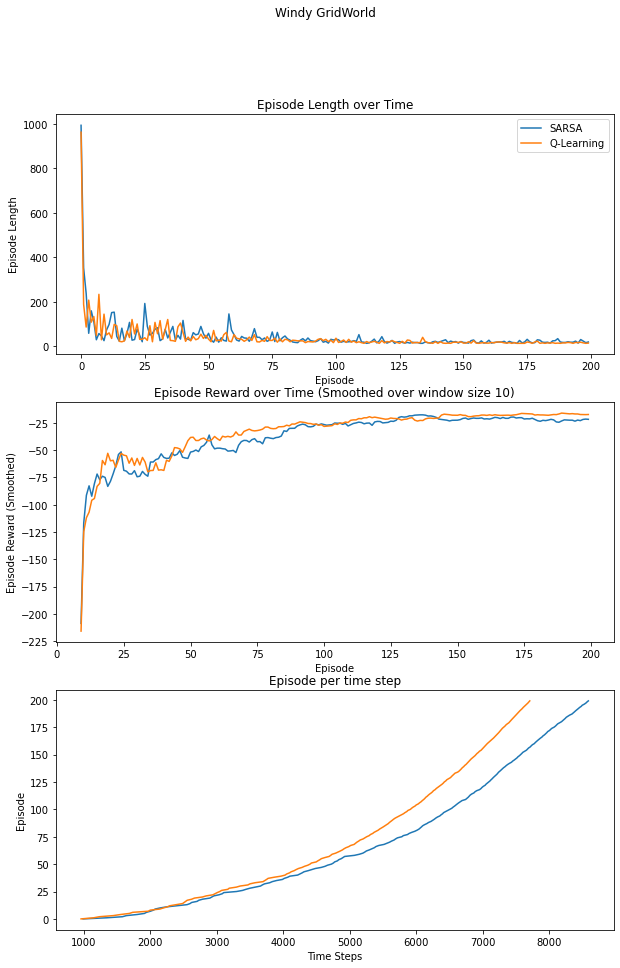

In [150]:
# Plot results for the Windy Gridworld environment
fig, ax = plt.subplots(3, 1, figsize=(10, 15))
fig.suptitle("Windy GridWorld")
plot_episode_lengths(ax[0], sarsa_stats1.episode_lengths, label='SARSA')
plot_episode_lengths(ax[0], Q_stats1.episode_lengths, label='Q-Learning')

plot_reward(ax[1], sarsa_stats1.episode_rewards, smoothing_window=10, label='SARSA')
plot_reward(ax[1], Q_stats1.episode_rewards, smoothing_window=10, label='Q-Learning')

plot_episode_per_timestep(ax[2], sarsa_stats1.episode_lengths, label='SARSA')
plot_episode_per_timestep(ax[2], Q_stats1.episode_lengths, label='Q-Learning')

ax[0].legend()

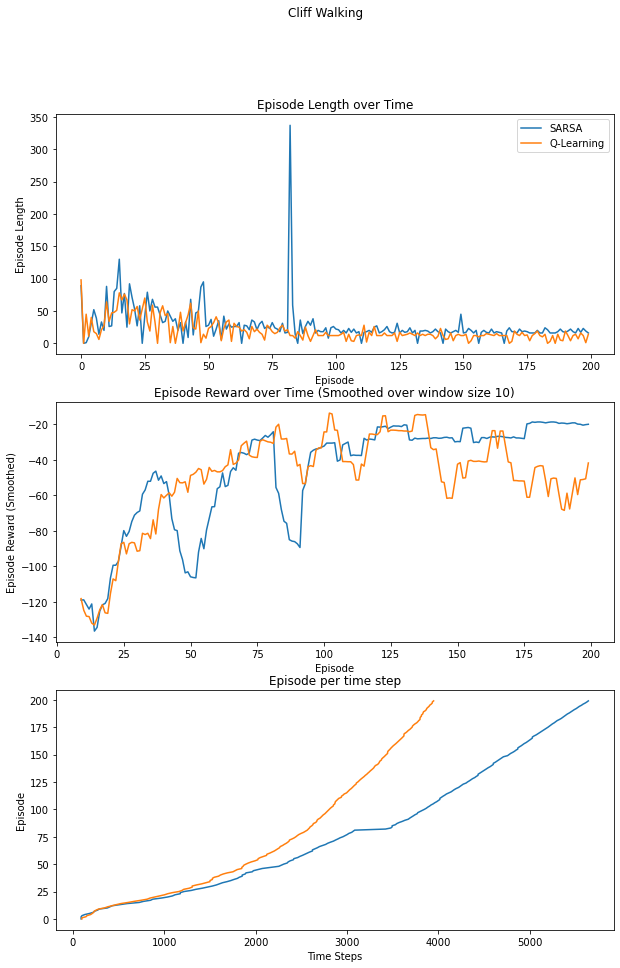

In [151]:
# Plot results for the Windy Gridworld environment
fig, ax = plt.subplots(3, 1, figsize=(10, 15))
fig.suptitle("Cliff Walking")
plot_episode_lengths(ax[0], sarsa_stats2.episode_lengths, label='SARSA')
plot_episode_lengths(ax[0], Q_stats2.episode_lengths, label='Q-Learning')

plot_reward(ax[1], sarsa_stats2.episode_rewards, smoothing_window=10, label='SARSA')
plot_reward(ax[1], Q_stats2.episode_rewards, smoothing_window=10, label='Q-Learning')

plot_episode_per_timestep(ax[2], sarsa_stats2.episode_lengths, label='SARSA')
plot_episode_per_timestep(ax[2], Q_stats2.episode_lengths, label='Q-Learning')
ax[0].legend()